# Setup the PEST(++) interface around the enhanced Freyberg model

In this notebook, we will construct a complex model independent (non-intrusive) interface around an existing MODFLOW-NWT model using the python/flopy/pyemu stack.

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu
import prep_deps

flopy is installed in /Users/jeremyw/Dev/gw1876/activities_2day_mfm/notebooks/flopy


In [2]:
b_d = os.path.join("..","base_model_files")
nam_file = "freyberg.nam"

### load the model and run once to make sure everything is good-to-go

In [3]:
m = flopy.modflow.Modflow.load(nam_file,model_ws=b_d,check=False,forgive=False)


In [4]:
m.exe_name = "mfnwt"
m.change_model_ws("temp",reset_external=True)
m.write_input()
prep_deps.prep_template(t_d="temp")
pyemu.os_utils.run("{0} {1}".format("mfnwt",m.name+".nam"),cwd=m.model_ws)


changing model workspace...
   temp


[Text(0, 0, 'historic'), Text(0, 0, 'scenario')]

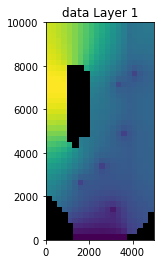

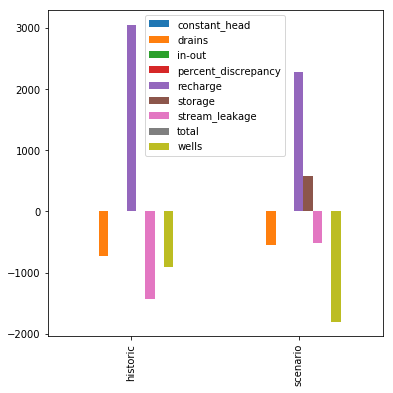

In [5]:
hds = flopy.utils.HeadFile(os.path.join(m.model_ws,m.name+".hds"),model=m)
hds.plot(mflay=0)
lst = flopy.utils.MfListBudget(os.path.join(m.model_ws,m.name+".list"))
df = lst.get_dataframes(diff=True)[0]
ax = df.plot(kind="bar",figsize=(6,6))
ax.set_xticklabels(["historic","scenario"])

We can see the effect of the "scenario" in the second stress period with less recharge and more abstraction. However, what we are going to do is implement this scenario with parameters so we can more easy account for the stochastic nature of the forcing conditions during the scenario stress period and also make implemention of future scenarios work in this stochastic framework:

[Text(0, 0, 'historic'), Text(0, 0, 'scenario')]

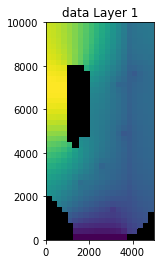

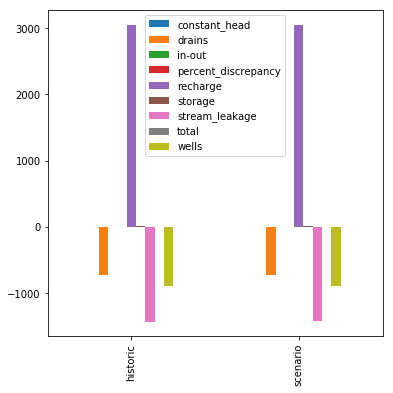

In [6]:
# reset scenario period recharge
m.rch.rech[1] = m.rch.rech[0]
# reset scenario period abstraction
m.wel.stress_period_data[1] = m.wel.stress_period_data[0]
m.write_input()
pyemu.os_utils.run("{0} {1}".format("mfnwt",m.name+".nam"),cwd=m.model_ws)
hds = flopy.utils.HeadFile(os.path.join(m.model_ws,m.name+".hds"),model=m)
axes = hds.plot(mflay=0)

lst = flopy.utils.MfListBudget(os.path.join(m.model_ws,m.name+".list"))
df = lst.get_dataframes(diff=True)[0]
ax = df.plot(kind="bar",figsize=(6,6))
ax.set_xticklabels(["historic","scenario"])

Now we see that the scenario and historic periods have the same water balance

### setup data structures related to what we want to parameterize and what we want to observe

In [7]:
props = []
paks = ["upw.hk","upw.vka","upw.ss","upw.sy","bas6.strt"]
for k in range(m.nlay):
    props.extend([[p,k] for p in paks])
props.append(["rch.rech",0])
props.append(["rch.rech",1])


In [8]:
spatial_list_props = [["wel.flux",2],["drn.cond",0]]
temporal_list_props = [["wel.flux",0],["wel.flux",1]]

In [9]:
hds_kperk = [[0,k] for k in range(m.nlay)]
hds_kperk.extend([[1,k] for k in range(m.nlay)])

Here we setup monitoring of the SFR ASCII outputs.  we will accumulate the first 20 reaches and last 20 reaches together to form forecasts of sw-gw exchange in the headwaters (`hw`) and tailwaters (`tw`).  Then we will also add each reach individually for monitoring as well

In [10]:
sfr_obs_dict = {"hw":np.arange(1,21)}
sfr_obs_dict["tw"] = np.arange(20,40)
for i in range(m.nrow):
    sfr_obs_dict[i] = i+1

### here we go...

This class has grown into a monster...it does (among other things):
- sets up combinations of multiplier parameters for array inputs, including uniform, zones, pilot points, grids, and KL expansion types
- sets up combinations of multiplier parmaeters for list inputs
- handles several of the shitty modflow exceptions to the array and list style inputs
- sets up large numbers of observations based on arrays or time series
- writes .tpl, .ins, .pst, etc
- writes a python forward run script (WAT?!)
- writes a prior parameter covaraince matrix using geostatistical correlations
- draws from the prior parameter covariance matrix to generate a prior parameter ensemble


In [11]:
pst_helper = pyemu.helpers.PstFromFlopyModel(nam_file,new_model_ws="template",org_model_ws="temp",
                                            const_props=props,spatial_list_props=spatial_list_props,
                                             temporal_list_props=temporal_list_props,remove_existing=True,
                                            grid_props=props,pp_props=props,sfr_pars=True,hds_kperk=hds_kperk,
                                             sfr_obs=sfr_obs_dict,build_prior=False,model_exe_name="mfnwt",
                                            pp_space=3)
prep_deps.prep_template(t_d=pst_helper.new_model_ws)

2019-04-28 15:06:02.616574 starting: loading flopy model

Creating new model with name: freyberg
--------------------------------------------------

Parsing the namefile --> temp/freyberg.nam

--------------------------------------------------
External unit dictionary:
OrderedDict([(2, filename:temp/freyberg.list, filetype:LIST), (11, filename:temp/freyberg.dis, filetype:DIS), (13, filename:temp/freyberg.bas, filetype:BAS6), (31, filename:temp/freyberg.upw, filetype:UPW), (19, filename:temp/freyberg.rch, filetype:RCH), (32, filename:temp/freyberg.nwt, filetype:NWT), (14, filename:temp/freyberg.oc, filetype:OC), (30, filename:temp/freyberg.lmt6, filetype:LMT6), (20, filename:temp/freyberg.wel, filetype:WEL), (17, filename:temp/freyberg.sfr, filetype:SFR), (21, filename:temp/freyberg.drn, filetype:DRN), (50, filename:temp/freyberg.cbc, filetype:DATA(BINARY)), (51, filename:temp/freyberg.hds, filetype:DATA(BINARY)), (60, filename:temp/freyberg.sfr.out, filetype:DATA)])
-------------------

The `pst_helper` instance contains the `pyemu.Pst` instance:

In [12]:
pst = pst_helper.pst
pst.npar,pst.nobs

(13200, 4434)

Oh snap!

We need to set some realistic parameter bounds and account for expected (but stochastic) scenario conditions:

In [13]:
par = pst.parameter_data
# properties
tag_dict = {"hk":[0.1,10.0],"vka":[0.1,10],"strt":[0.95,1.05]}
for t,[l,u] in tag_dict.items():
    t_pars = par.loc[par.parnme.apply(lambda x: t in x ),"parnme"]
    par.loc[t_pars,"parubnd"] = u
    par.loc[t_pars,"parlbnd"] = l

# recharge - just change the uniform recharge mult
scen_rch = ["rech5_cn"]
hist_rch = ["rech4_cn"]
par.loc[par.pargp.apply(lambda x: x in scen_rch),"parubnd"] = 0.8
par.loc[par.pargp.apply(lambda x: x in scen_rch),"parlbnd"] = 0.1
par.loc[par.pargp.apply(lambda x: x in scen_rch),"parval1"] = 0.4
par.loc[par.pargp.apply(lambda x: x in hist_rch),"parubnd"] = 1.2
par.loc[par.pargp.apply(lambda x: x in hist_rch),"parlbnd"] = 0.8
par.loc[par.pargp.apply(lambda x: x in hist_rch),"parval1"] = 1.0

# well abstraction
par.loc["welflux_001","parval1"] = 1.5
par.loc["welflux_001","parlbnd"] = 1.0
par.loc["welflux_001","parubnd"] = 2.0
par.loc["welflux_000","parval1"] = 1.0
par.loc["welflux_000","parlbnd"] = 0.5
par.loc["welflux_000","parubnd"] = 1.5



In [14]:
# table can also be written to a .tex file
pst.write_par_summary_table(filename="none").sort_index()

,type,transform,count,initial value,upper bound,lower bound,standard deviation
drncond_k00,drncond_k00,log,10,0,1,-1,0.5
flow,flow,log,1,0,0.09691,-0.124939,0.0554622
grhk3,grhk3,log,705,0,1,-1,0.5
grhk4,grhk4,log,705,0,1,-1,0.5
grhk5,grhk5,log,705,0,1,-1,0.5
grrech2,grrech2,log,705,0,0.0413927,-0.0457575,0.0217875
grrech3,grrech3,log,705,0,0.0413927,-0.0457575,0.0217875
grss3,grss3,log,705,0,1,-1,0.5
grss4,grss4,log,705,0,1,-1,0.5
grss5,grss5,log,705,0,1,-1,0.5


In [15]:
pst.write_obs_summary_table(filename="none")

,group,value,non-zero weight,zero weight,weight,standard deviation,percent error
flaqx,flaqx,-1013.42 to 32.171,84,0,1,1,0.0986757 to 833.333
flout,flout,10069 to 226396,84,0,1,1,0.000441704 to 0.00993147
hds,hds,32.5065 to 39.6612,4230,0,1,1,2.52136 to 3.07631
obgnme,obgnme,1E+10,36,0,1,1,1E-08


Lets run the process once (`noptmax=0`) to make sure its all plumbed up

In [16]:
pst.control_data.noptmax = 0
pst.write(os.path.join(pst_helper.new_model_ws,"freyberg.pst"))
pyemu.os_utils.run("pestpp-ies freyberg.pst",cwd=pst_helper.new_model_ws)


Now we need to generate the prior parameter covariance matrix and stochastic realizations.  We will use the geostatistical covariance information in the `pst_helper` instance for this:

2019-04-28 15:06:28.098271 starting: building prior covariance matrix
2019-04-28 15:06:28.194162 WARNING: geospatial prior not implemented for SFR pars


/Users/jeremyw/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jeremyw/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


2019-04-28 15:06:33.611545 saving prior covariance matrix to file template/prior_cov.jcb
[[0.11111111 0.10053749 0.09097008 ... 0.         0.         0.        ]
 [0.10053749 0.11111111 0.10053749 ... 0.         0.         0.        ]
 [0.09097008 0.10053749 0.11111111 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.11111111 0.0673923  0.04871123]
 [0.         0.         0.         ... 0.0673923  0.11111111 0.05088182]
 [0.         0.         0.         ... 0.04871123 0.05088182 0.11111111]]
<class 'numpy.ndarray'>
2019-04-28 15:06:37.151700 finished: building prior covariance matrix took: 0:00:09.053429


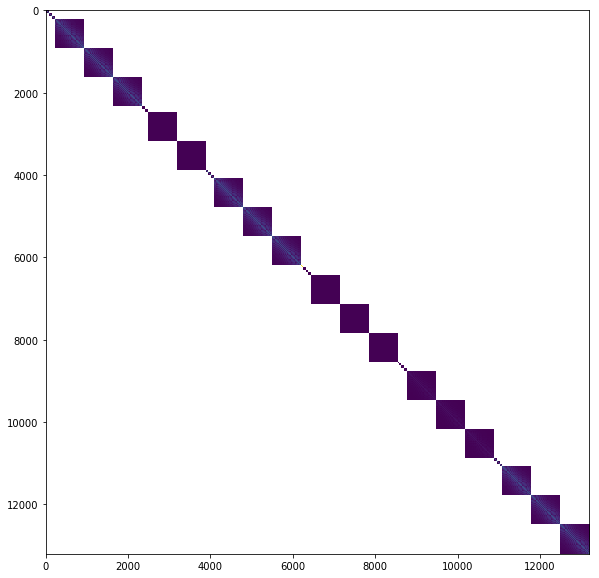

In [17]:
cov = pst_helper.build_prior(fmt="binary",filename=os.path.join(pst_helper.new_model_ws,"prior_cov.jcb"))
cov = np.ma.masked_where(cov.x==0,cov.x)
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
ax.imshow(cov)

Boom!  10K+ parameter covariance matrix

In [18]:
pe = pst_helper.draw(200)

2019-04-28 15:06:51.941861 starting: drawing realizations
building diagonal cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:750.0,anisotropy:1.0,bearing:0.0

working on pargroups ['pp_hk0']
build cov matrix
done
getting diag var cov 67
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargroups ['pp_vka0']
build cov matrix
done
getting diag var cov 67
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargroups ['pp_ss0']
build cov matrix
done
getting diag var cov 67
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargroups ['pp_sy0']
build cov matrix
done
getting diag var cov 67
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargroups ['pp_strt0']
build cov matrix
done
getting diag var cov 67
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargr

/Users/jeremyw/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jeremyw/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargroups ['welflux_k02']
build cov matrix
done
getting diag var cov 6
scaling full cov by diag var cov
making full cov draws with home-grown goodness
adding remaining parameters to diagonal
2019-04-28 15:06:58.911101 finished: drawing realizations took: 0:00:06.969240


You can see that parameters are treated in parameter group (`pargp`) blocks for this ensemble generation.  Let's plot one parameter:

<Figure size 576x756 with 0 Axes>

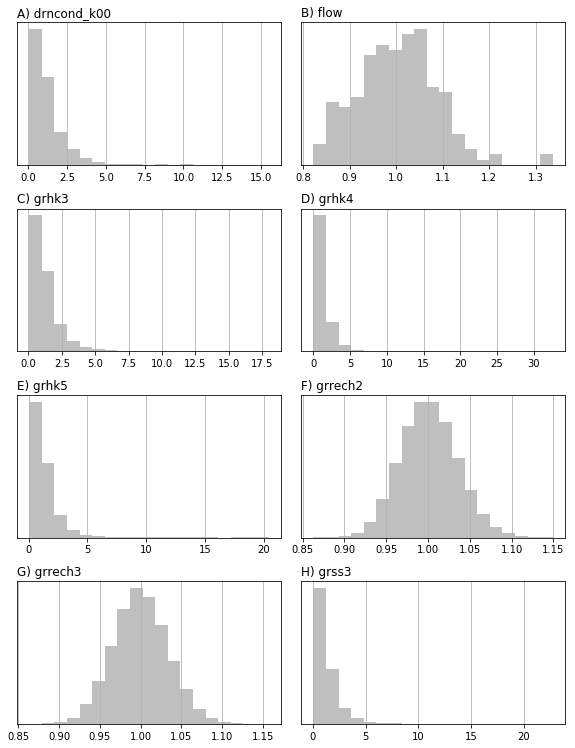

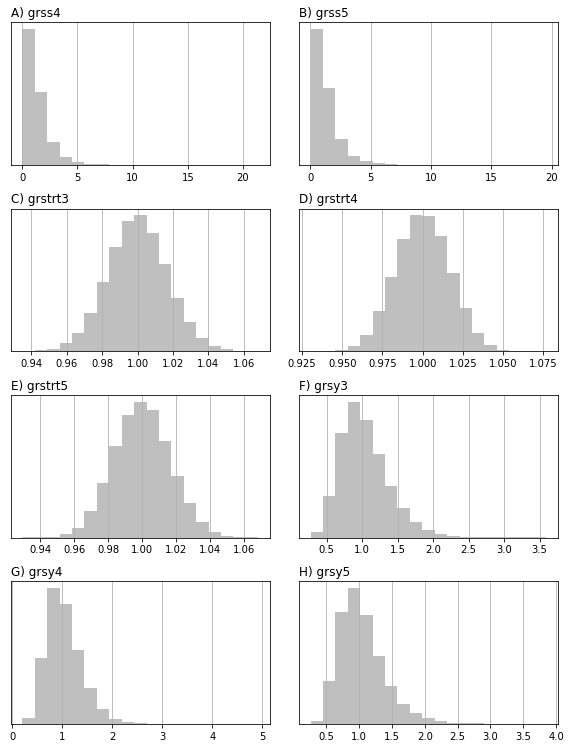

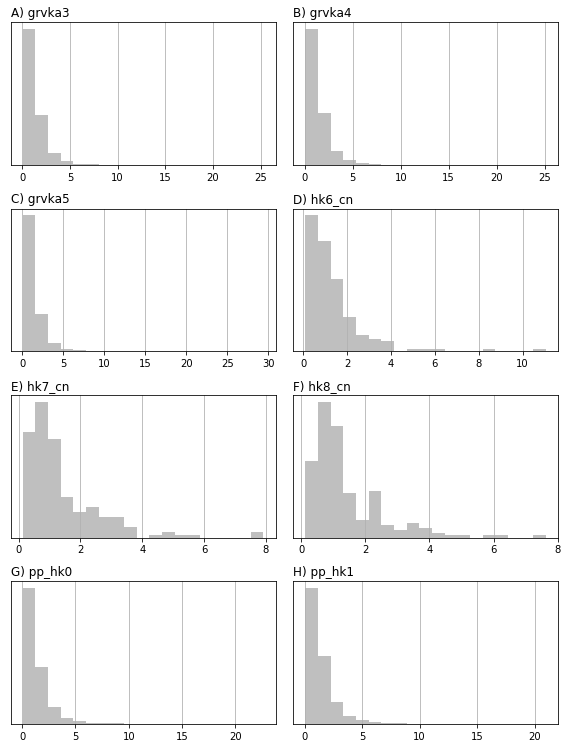

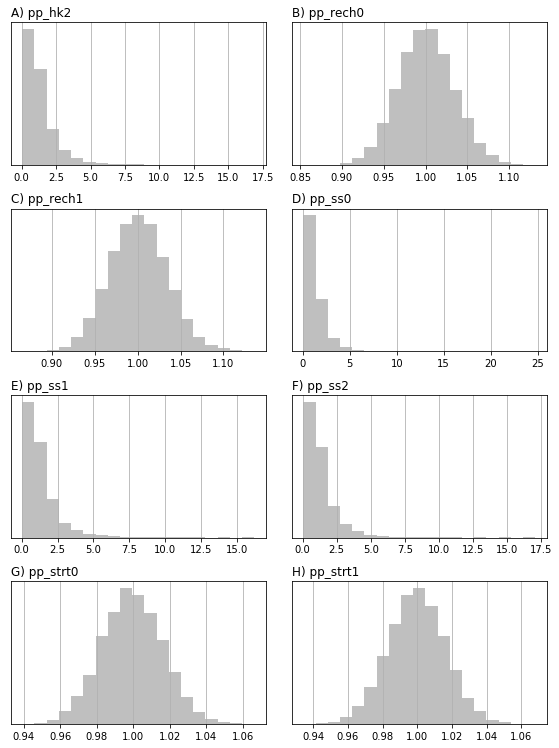

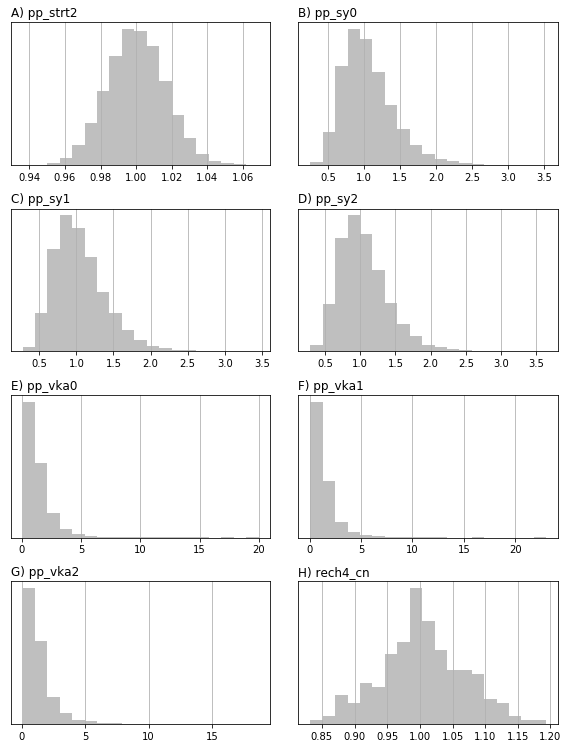

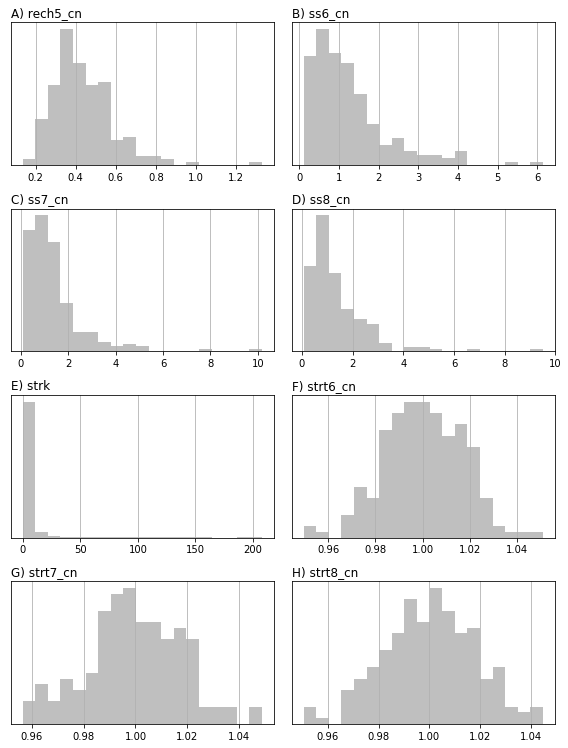

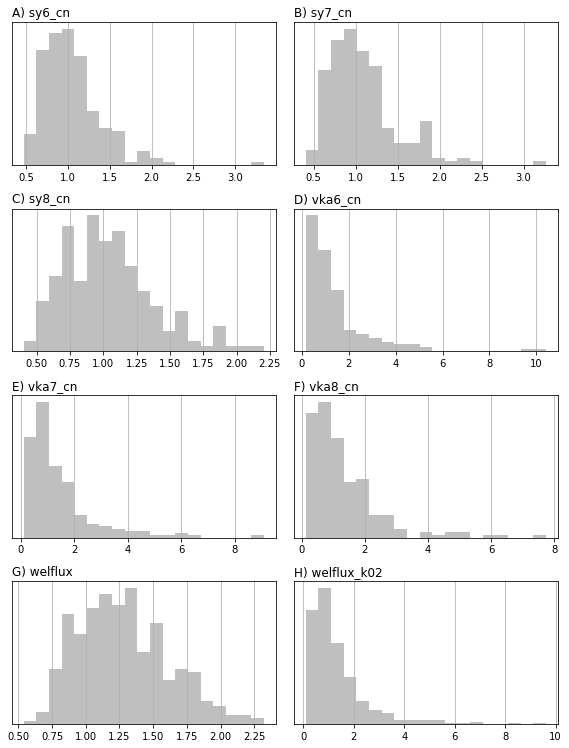

In [19]:
par = pst_helper.pst.parameter_data
pyemu.plot_utils.ensemble_helper(pe,plot_cols=par.groupby("pargp").groups,bins=20)

Now we need to enforce parameter bounds and save this ensemble for later

In [20]:
pe.enforce()
pe.to_binary(os.path.join(pst_helper.new_model_ws,"prior.jcb"))

### set weights for "observations" and identify forecasts

The next major task is to set the weights on the observations.  So far, in the `pst_helper` process, we simply identified what outputs from the model we want to observe.  We now use a pre-cooked csv file to set nonzero weights only for GW level observation locations used in the original Freyberg model.  We will also use the SFR flow out of the last reach (`fo_39_19791230`)

In [21]:
obs_locs = pd.read_csv(os.path.join("..","base_model_files","obs_loc.csv"))
#build obs names that correspond to the obsnme values in the control file
obs_locs.loc[:,"obsnme"] = obs_locs.apply(lambda x: "hds_00_{0:03d}_{1:03d}_000".format(x.row-1,x.col-1),axis=1)
obs_locs

,row,col,obsnme
0,3,16,hds_00_002_015_000
1,3,10,hds_00_002_009_000
2,4,9,hds_00_003_008_000
3,10,2,hds_00_009_001_000
4,14,11,hds_00_013_010_000
5,16,17,hds_00_015_016_000
6,22,11,hds_00_021_010_000
7,23,16,hds_00_022_015_000
8,25,5,hds_00_024_004_000
9,27,7,hds_00_026_006_000


Set all weights to zero first, then turn on the weights at only a few locations.  These nonzero obs will be given meaningful weights in the prior monte carlo excersize|

In [22]:
obs = pst_helper.pst.observation_data
obs.loc[:,"weight"] = 0.0
obs.loc[obs_locs.obsnme,"weight"] = 1.0
obs.loc[obs_locs.obsnme,"obgnme"] = "calhead"
obs.loc["fo_39_19791230","weight"] = 1.0
obs.loc["fo_39_19791230","obgnme"] = "calflux"
pst.nnz_obs_names

['fo_39_19791230',
 'hds_00_002_009_000',
 'hds_00_002_015_000',
 'hds_00_003_008_000',
 'hds_00_009_001_000',
 'hds_00_013_010_000',
 'hds_00_015_016_000',
 'hds_00_021_010_000',
 'hds_00_022_015_000',
 'hds_00_024_004_000',
 'hds_00_026_006_000',
 'hds_00_029_015_000',
 'hds_00_033_007_000',
 'hds_00_034_010_000']

Now we will define which model outputs are going to be treated as "forecasts" and save the control file

In [23]:
swgw_forecasts = obs.loc[obs.obsnme.apply(lambda x: "fa" in x and ("hw" in x or "tw" in x)),"obsnme"].tolist()
hds_forecasts = obs.loc[obs.obsnme.apply(lambda x: "hds_00_015_002" in x),"obsnme"].tolist()
forecasts = swgw_forecasts
forecasts.extend(hds_forecasts)
pst_helper.pst.pestpp_options["forecasts"] = forecasts
pst.write(os.path.join(pst_helper.new_model_ws,"freyberg.pst"))

Run one last time.  `phi` should be near zero since we haven't change the `parval1` values for historic stress period and only the 13 gw level obs have nonzero weights

In [24]:
pyemu.os_utils.run("pestpp-ies.exe freyberg.pst",cwd=pst_helper.new_model_ws)
pst = pyemu.Pst(os.path.join(pst_helper.new_model_ws,"freyberg.pst"))
pst.phi

9.456182577320024e-19

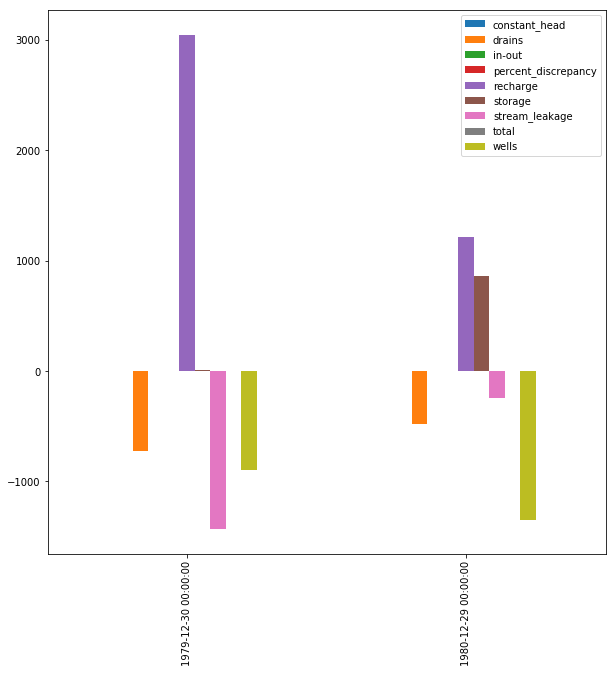

In [25]:
lst = flopy.utils.MfListBudget(os.path.join("template","freyberg.list"))
df = lst.get_dataframes(diff=True)[0]
df.plot(kind="bar",figsize=(10,10))

We see the effect of our parameterized scenario - a large drop in recharge and more abstraction.